Generate instance, solve, draw BER.
Generate fixed point instance for FPGA test

# Create Path for files

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import commpy as comm
import cmath
import numpy as np
import math
from scipy.sparse import coo_matrix
import os

# common_path = 'G:/Cornell/QuAIL/codes/CIMSimulator/instances/MIMO_decoding/di_mimo/'
common_path = './tb_data/'

path_to_all_instances = common_path + 'instances/'
path_to_all_solutions = common_path + 'ideal_solutions/'
path_to_all_solved    = common_path + 'solved_solutions/'

path_to_all_HLS_tb    = common_path + 'HLS_tb_data/' # for HLS tb
#TODO: path_to_all_HLS_tb is not consistent with the HLS code tb yet

# Check whether the specified path exists or not
isExist = os.path.exists(path_to_all_instances)
if not isExist:
    # Create a new directory because it does not exist 
    os.makedirs(path_to_all_instances)
    print("Created new directory for problem instances")
else:
    print("Directory for problem instances already exists")
print("Directory for problem instances: ", path_to_all_instances)

# Check whether the specified path exists or not
isExist = os.path.exists(path_to_all_solutions)
if not isExist:
    # Create a new directory because it does not exist 
    os.makedirs(path_to_all_solutions)
    print("Created new directory for solutions")
else:
    print("Directory for solutions already exists")
print("Directory for solutions: ", path_to_all_solutions)

# Check whether the specified path exists or not
isExist = os.path.exists(path_to_all_solved)
if not isExist:
    # Create a new directory because it does not exist 
    os.makedirs(path_to_all_solved)
    print("Created new directory for solutions")
else:
    print("Directory for solutions already exists")
print("Directory for solutions: ", path_to_all_solved)

# Check whether the specified path exists or not
isExist = os.path.exists(path_to_all_HLS_tb)
if not isExist:
    # Create a new directory because it does not exist 
    os.makedirs(path_to_all_HLS_tb)
    print("Created new directory for solutions")
else:
    print("Directory for solutions already exists")
print("Directory for solutions: ", path_to_all_HLS_tb)


Directory for problem instances already exists
Directory for problem instances:  ./tb_data/instances/
Directory for solutions already exists
Directory for solutions:  ./tb_data/ideal_solutions/
Directory for solutions already exists
Directory for solutions:  ./tb_data/solved_solutions/
Directory for solutions already exists
Directory for solutions:  ./tb_data/HLS_tb_data/


## Create Instances

In [95]:
#N_t x N_r MIMO

N_t = 16                #Number Of Transmit antennas
N_r = 16                #Number of Receive antennas
modulation = 16         #Type of modulation
numInstances = 10       #Number of Ising Instances to generate

bits_per_symbol = int(math.log2(modulation))

bitsPerEntry = int(0.5*bits_per_symbol)

maxQI = 2*np.sqrt(modulation/4) - 1

_qam = comm.QAMModem(modulation)

totalBits = bits_per_symbol*N_t

# snr_list = [20, 30, 50, 70, 100] ## in dB
snr_list = [25] ## in dB
print("snr_list: ", snr_list)

instance_type = "Nt"+str(N_t)+"_Nr"+str(N_r)+"_"+str(modulation)+"QAM/"
print("instance_type: ", instance_type)


snr_list:  [25]
instance_type:  Nt16_Nr16_16QAM/


In [96]:
H = np.zeros((N_r,N_t),dtype=np.complex128)

# ## Seed for verification
# np.random.seed(1)

numInstances = 1000

for snr in snr_list:
  path_to_instances = path_to_all_instances + instance_type + str(snr) + "/"
  path_to_solutions = path_to_all_solutions + instance_type + str(snr) + "/"

  # Check whether the specified path exists or not
  isExist = os.path.exists(path_to_instances)

  if not isExist:
      # Create a new directory because it does not exist 
      os.makedirs(path_to_instances)
      print("Created new directory for problem instances for snr ", snr, " in", path_to_instances)
  else:
      print("Directory for problem instances for snr ", snr, " already exists in", path_to_instances)

  # Check whether the specified path exists or not
  isExist = os.path.exists(path_to_solutions)

  if not isExist:
      # Create a new directory because it does not exist 
      os.makedirs(path_to_solutions)
      print("Created new directory for ideal solutions for snr ", snr)
  else:
      print("Directory for ideal solutions for snr ", snr, " already exists")

  ## Generate random channel matrices (complex)
  for k in range(numInstances):
    H = (1/np.sqrt(2))*(np.random.randn(N_r, N_t) + 1j*np.random.randn(N_r, N_t))

    ## Generate random transmissions
    x = np.zeros((N_t),dtype=np.complex128)

    for i in range(N_t):
      x[i] = _qam.modulate(comm.utilities.dec2bitarray(np.random.randint(0,modulation-1),bits_per_symbol))

    y = np.zeros((N_r),dtype=np.complex128)

    ## Find the corresponding received vectors
    y_rec = np.matmul(H,x)

    ## Add noise
    ey2 = np.mean(np.abs(y)**2)
    
    # var = ey2/(10**(snr/10)) 
    var = ey2*(10**(-1*snr/10))
    
    y += np.sqrt(0.5) * (np.random.normal(scale=np.sqrt(var), size=(N_r)) + 1j*np.random.normal(scale=np.sqrt(var), size=(N_r)))

    temp = np.conjugate(H.T)@H
    # noise_correction = (1/(10**(snr/10))) * np.identity(np.shape(H)[1])
    noise_correction = (10**(-1*snr/10)) * np.identity(np.shape(H)[1])
    
    D = np.linalg.inv(temp + noise_correction)@(np.conjugate(H.T))

    x_mmse = _qam.modulate(_qam.demodulate(D@y_rec, "hard"))

    ## J is the internal field matrix for the Ising problem
    J = np.zeros((4*N_t,4*N_t))
    ## h is the external field. We can get rid of this by adding an 
    ## auxiliary spin (shown in paper)
    h = np.zeros((4*N_t))

    y = y_rec - H@x_mmse

    ## Transformation from complex matrices to real-valued matrices
    ## (refer to paper for more details)
    t1 = np.concatenate((H.real,-1*H.imag),axis=1)
    t2 = np.concatenate((H.imag, H.real),axis=1)

    H_r = np.concatenate((t1,t2),axis=0)
    y_r = np.concatenate((y.real,y.imag),axis=0)

    j_temp = H_r.T @ H_r
    J1 = np.hstack((j_temp, j_temp))
    J1 = -np.vstack((J1, J1))

    h_temp = 2*(y_r.T@H_r)
    h1 = np.concatenate((h_temp, h_temp), axis=0)

    np.fill_diagonal(J1, 0)

    max_J = np.absolute(J1).max()
    max_h = np.absolute(h1).max()

    ## Scale to keep all entries between -1 and 1
    scale = max(max_J,max_h)
    J = J1/scale
    h = h1/(2*scale)

    ## Save the expected solution
    with open(path_to_solutions + "DI_MIMO_sol_" + str(k) + ".txt", "w") as file:
      #file.write("##\t"  + str(len(x)) + "\n")
      np.savetxt(file, x)

    with open(path_to_solutions + "DI_MIMO_mmse_sol_" + str(k) + ".txt", "w") as file:
      #file.write("##\t"  + str(len(x)) + "\n")
      np.savetxt(file, x_mmse)
    
    # Recast as pure quadratic and save for running in HLS
    h_reshaped = np.reshape(h, (1, 4*N_t))
    J_temp = np.vstack((J, h_reshaped))

    h_temp = h_reshaped.T
    h_temp = np.reshape(np.append(h_temp, 0), (4*N_t + 1, 1))
    J_quad = np.hstack((J_temp, h_temp))

    file = open(path_to_instances + "DI_MIMO_J_Quad_" + str(k) + ".txt", "w")
    np.savetxt(file, J_quad)
    file.close()

Created new directory for problem instances for snr  25  in ./tb_data/instances/Nt16_Nr16_16QAM/25/
Created new directory for ideal solutions for snr  25


# Solver (matrix formulation)

*parameters used on simulation below*
```python
CIM_AHC_tf(
    total_time=2.56, J, time_step=0.01, 
    r=0.98, mu = 1, beta=1, target_a_baseline=0, 
    num_anneals=64, coupling_str=100, 
    use_sign=1, gamma=1/2.56, modulate_parameter="target_a",
    add_noise=1, use_last = 0
)
```

In [303]:
def CIM_AHC(T_time, J, time_step, r=0.2, beta=0.05, coupling_str=0.07, mu=1, noise=0, ground_energy=0, num_anneals = 1, target_a_baseline = 0.2, use_sign=0, gamma=1):
    np.random.seed(1)
    N = J.shape[1]

    ticks = int(T_time/time_step) #actual number of steps
    plot_data = np.zeros((N,ticks))

    best_energy = 0
    best_sol = None
    best_energies = None
    best_time = 0

    best_plot_data = None

    for run in range(num_anneals):

        #r = Linear Gain
        #beta = Error Variable Rate of Change
        
        #coupling_str = Coupling Strength (F_J coefficient)
        target_a = target_a_baseline
        x = 0.001 * np.random.rand(N) - 0.0005


        error_var = np.ones(N)
        etc_flag = np.ones(N)


        energies = []
        sig = np.sign(x)
        best_energy_run = -1/2*(J.dot(sig)).dot(sig)
        best_sol_run = x

        for t in range(ticks):
            plot_data[:,t] = x 
            # print("\nTime Step ", t)
            # print("x = ", x)
            # print("e = ", error_var)

            if t > 1:
                prev_signs = np.sign(plot_data[:, t-1])
                compare_signs = prev_signs != np.sign(x)
                comparison = compare_signs.any()
                if comparison:
                    etc_flag = error_var
                else:
                    etc_flag = etc_flag #np.ones(N)

            #Evolve Spin Variables
            xx = x**2

            if use_sign:
                MVM = (J).dot(np.sign(x))
            else:    
                MVM = (J).dot(x)

           
            dx = time_step*coupling_str*(MVM)*error_var
            #print("coupling str ter", dx)
            x += dx
            
            x+= time_step*(x*((r-1) - mu*xx))

           

            sig = np.sign(x)
            #Modulate Target Amplitude

            delta_a = gamma * time_step
            #coupling_str*np.mean((J.dot(sig))*sig*etc_flag)
            target_a  = target_a_baseline + delta_a

            #Evolve Error Variables
            xx = x**2
            error_var += time_step*(-beta*((xx) - target_a)*error_var)
            #print(error_var)
            # plot_data[:,t] = x
            curr_ising_energy = -1/2*(J.dot(sig)).dot(sig)
            #print(curr_ising_energy)
            energies.append(curr_ising_energy)

            if curr_ising_energy < best_energy_run:
                best_energy_run = curr_ising_energy
                best_sol_run = x
                best_time = t
            # if ground_energy != 0:
            #     if curr_ising_energy <= ground_energy:
            #         print("Solved at time ", t)
            #         return (plot_data, t)

        if best_energy_run < best_energy:
            best_energy = best_energy_run
            best_sol = best_sol_run
            best_energies = energies
            best_plot_data = plot_data

    
    return (best_plot_data, best_energies, np.sign(best_sol), best_energy)

Reading file  ./tb_data/instances/Nt16_Nr16_16QAM/25/DI_MIMO_J_Quad_9.txt
Best energy =  -25.844282790790192
SNR= 25
-25.844282790790192


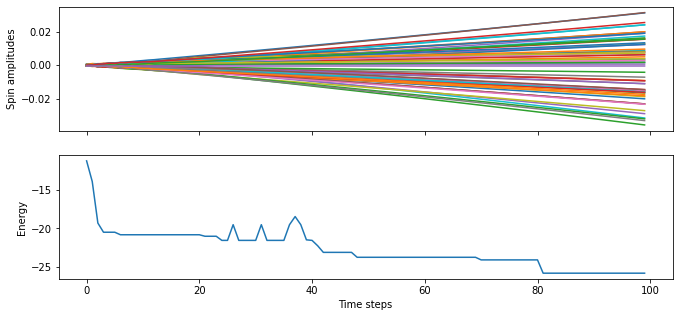

In [128]:
# num_anneals = 64
num_anneals = 40

N=65
N_steps = 100
time_step = 0.01
total_time = N_steps * time_step

r = 0.98
mu = 1
beta = 1
target_a_baseline = 0.2
gamma = 1/(N_steps * time_step)
coupling_str = 0.02

use_sign = 1
use_last = 0
add_noise = 0

# snr_list = [100]
# numInstances = 500

# ## Seed for verification
# np.random.seed(1)


numInstances=200
for snr in snr_list:
    path_to_instances = path_to_all_instances + instance_type + str(snr) + "/"
    path_to_solutions = path_to_all_solutions + instance_type + str(snr) + "/"
    path_to_solved = path_to_all_solved + instance_type + str(snr) + "/"

    # Check whether the specified path exists or not
    isExist = os.path.exists(path_to_instances)

    if not isExist:
        print("No instances for snr = ", snr)

    # Check whether the specified path exists or not
    isExist = os.path.exists(path_to_solved)

    if not isExist:
        os.makedirs(path_to_solved)
        print("Created new directory for solved snr=", snr)

    for k in range(9, 10):
        file = open(path_to_instances + "DI_MIMO_J_Quad_" + str(k) + ".txt", "r")
        print("Reading file ", path_to_instances + "DI_MIMO_J_Quad_" + str(k) + ".txt")
        J = np.loadtxt(file)
        J= J
        file.close()
        N = len(J)

        data, energies, solution, best_energy = CIM_AHC(total_time, J, time_step, r=r, beta=beta, coupling_str=coupling_str, mu=1, noise=0, ground_energy=0, num_anneals = num_anneals, target_a_baseline = 0.2, use_sign=1, gamma=gamma)
        #data, energies, solution, best_energy = CIM_AHC_alt_fixed(total_time, J, time_step, r=r, beta=beta, gamma=gamma, coupling_str=coupling_str, mu=mu, noise=0, num_anneals = num_anneals, target_a_baseline = 0.2, use_sign=1, modulate_parameter="target_a")

        #CIM_AHC_tf(total_time, J, time_step=time_step, \
         #   r=r, mu = 1, beta=beta, target_a_baseline=target_a_baseline, \
         #       num_anneals=num_anneals, coupling_str=coupling_str, \
          #      use_sign=use_sign, gamma=gamma, modulate_parameter="target_a", add_noise=add_noise) 
         #
        
        
          # target_a or coupling_str
                
        # print("Best energy = ", best_energy)
        
        print("Best energy = ", best_energy)
        
        # when solution is all zero, means the algorithm converge
        n = 2*N_t
        #print("solution.shape=", solution.shape)
        #print(solution[0:n]+solution[n:2*n])
        
        file = open(path_to_solved +  "DI_MIMO_sol_" + str(k) + ".txt", "w")
        np.savetxt(file, solution, fmt="%s")
        file.close()

fig, ax = plt.subplots(2,1, sharex = True, figsize=(11,5))

for i in range(N):
    ax[0].plot(data[i,:])

print("SNR=", snr_list[-1])
ax[0].set_ylabel("Spin amplitudes")
ax[1].plot(energies)
ax[1].set_ylabel("Energy")
plt.xlabel("Time steps")

print(-1/2*J.dot(solution).dot(solution))

snr_list [30]
ber_mmse [0.0]
ber [0.0]


Text(0, 0.5, 'BER')

c:\users\ari\programs\python\python38\lib\site-packages\matplotlib_inline\backend_inline.py:234: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  for label in axis.get_ticklabels()])


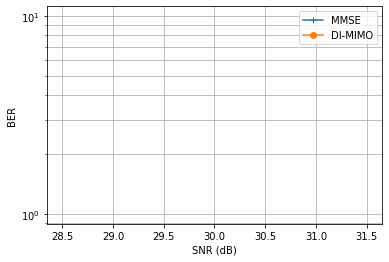

In [32]:
## This cell is to calculate the bit error rate once we have a solution

T = np.identity(2*N_t)
T = np.concatenate((T,T), axis=1)

ber = []
ber_mmse = []

for snr in snr_list:
  path_to_instances = path_to_all_instances + instance_type + str(snr) + "/"
  path_to_solutions = path_to_all_solutions + instance_type + str(snr) + "/"
  path_to_solved = path_to_all_solved + instance_type + str(snr) + "/"

  # Check whether the specified path exists or not
  isExist = os.path.exists(path_to_instances)

  if not isExist:
      print("No instances for snr = ", snr)
      break
  
  isExist = os.path.exists(path_to_solved)

  if not isExist:
      print("No solved solutions for snr = ", snr)
      break
  bitErrors = 0
  bitErrors_mmse = 0

  #For Ising Solution s corresponding decoded symbol in
  for k in range(0,26):
    # s = np.loadtxt(path_to_solved + "sol_" + str(k) + ".txt")
    file = open(path_to_solved + "DI_MIMO_sol_" + str(k) + ".txt", "r")
    s_quad = np.loadtxt(file)
    file.close()

    with open(path_to_solutions + "DI_MIMO_mmse_sol_" + str(k) + ".txt", "r") as file:
      x_mmse = np.loadtxt(file, dtype=np.complex128)

    s = s_quad[0:-1] * s_quad[-1]

    d = T@s
    x_mmse_r = np.concatenate((x_mmse.real,x_mmse.imag),axis=0)
    u = d + x_mmse_r

    u = u[0:N_t] + 1j*u[N_t:]

    b1 = _qam.demodulate(u,demod_type='hard')
    
    b_mmse = _qam.demodulate(x_mmse,demod_type='hard')

    with open(path_to_solutions + "DI_MIMO_sol_" + str(k) + ".txt", "r") as file:
      x = np.loadtxt(file, dtype=np.complex128)

    b2 = _qam.demodulate(x,demod_type='hard')

    bitErrors = bitErrors + sum(abs(b1-b2))
    bitErrors_mmse = bitErrors_mmse + sum(abs(b_mmse-b2))
  
  ber.append(bitErrors/(totalBits*numInstances))
  ber_mmse.append(bitErrors_mmse/(totalBits*numInstances))

print("snr_list", snr_list)
print("ber_mmse", ber_mmse)
print("ber", ber)

plt.semilogy(snr_list, ber_mmse, "+-")
plt.semilogy(snr_list, ber, "o-")
plt.legend(["MMSE", "DI-MIMO"])
plt.grid(True, which="both")
plt.xlabel("SNR (dB)")
plt.ylabel("BER")

In [82]:
from fxpmath import Fxp
def CIM_AHC_alt_fixed(T_time, J, time_step, r=0.2, beta=0.05, coupling_str=0.07, mu=1, gamma=1, noise=0, ground_energy=0, num_anneals = 1, target_a_baseline = 0.2, use_sign=0, modulate_parameter="target_a"):
    np.random.seed(1)
    N = J.shape[1]

    ticks = int(T_time/time_step) #actual number of steps
    plot_data = np.zeros((N,ticks))

    best_energy = 0
    best_sol = None
    best_energies = None
    best_time = 0

    best_plot_data = None
    n_total = 20
    n_frac = 15

    J_fxp = Fxp(J, True, n_total, n_frac)
    time_step_fxp = time_step
    time_step_fxp = Fxp(time_step, True, n_total, n_frac)

    mu = Fxp(mu, True, n_total, n_frac)
    beta = Fxp(beta, True, n_total, n_frac)
    gamma = Fxp(gamma, True, n_total, n_frac)


    for run in range(num_anneals):

        #r = Linear Gain
        #beta = Error Variable Rate of Change
        
        #coupling_str = Coupling Strength (F_J coefficient)
        
        target_a = target_a_baseline
        #target_a =  Fxp(target_a_baseline,True, n_total, n_frac)
        #coupling_str =  Fxp(coupling_str,True, 10, n_frac)
        #print("Target a", target_a)
        #x = 0.001 * np.random.rand(N) - 0.0005

        x = 0.001 * np.random.rand(N) - 0.0005

        x = Fxp(x,True, n_total, n_frac)

        error_var = np.ones(N)
        etc_flag = np.ones(N)
        error_var = Fxp(error_var, True, n_total, n_frac)
        
        #print(x)
        #x = np.array([0.0,-0.000488281,0, 0, -0.000488281, 0, 0, 0, -0.000488281, 0, 0, -0.000488281, -0.000488281, 0, -0.000488281, 0, -0.000488281, -0.000488281, -0.000488281, 0, -0.000488281, 0, -0.000488281, 0, -0.000488281, 0, 0, -0.000488281, -0.000488281, 0, 0, -0.000488281, 0, 0, 0, -0.000488281, -0.000488281, 0, 0, 0, -0.000488281, 0, 0, 0, -0.000488281, -0.000488281, -0.000488281, -0.000488281, 0, 0, 0, 0, -0.000488281, 0, -0.000488281, -0.000488281, -0.000488281, -0.000488281, -0.000488281, 0, 0, 0, 0, -0.000488281, 0])

      

        energies = []
        sig = np.sign(x)
        best_energy_run = -0.5 * np.sum(J_fxp() * np.outer(sig, sig), axis=None)
        best_sol_run = x

        for t in range(ticks):
            plot_data[:,t] = x 

            if t > 1:
                prev_signs = np.sign(plot_data[:, t-1])
                compare_signs = prev_signs != np.sign(x)
                comparison = compare_signs.any()
                if comparison:
                    etc_flag = error_var
                else:
                    etc_flag = etc_flag #np.ones(N)

            #Evolve Spin Variables
            #print("init x type", type(x))
            xx = x/4

            if use_sign:
                MVM = J_fxp.dot(np.sign(x))

            else:    
                MVM = (J).dot(x)



            deltax = Fxp((coupling_str * (MVM * error_var())), True, n_frac, n_total)

            deltax = Fxp(time_step_fxp*deltax, True, n_frac, n_total)
            x+= deltax

            deltax = Fxp((x * ((-0.02 - mu() * xx()))), True, n_total, n_frac)


 
            x+= Fxp((deltax*time_step_fxp), True, n_total, n_frac)
           

            sig = np.sign(x)
            #Modulate Target Amplitude
            
            if modulate_parameter == "target_a":
                delta_a = Fxp((gamma() * 0.01), True, n_total, n_frac)
                target_a = target_a_baseline + delta_a
            elif modulate_parameter == "coupling_str":
                coupling_str += Fxp((time_step_fxp() * gamma()), True, n_total, n_frac)

            #print(type(x))
            #print("before square x", x)

            #was x/8
            xx = x/4
    
            d_error_var = ((xx()) - target_a()) *error_var
            #print("derror_var", d_error_var)
            error_var += Fxp((d_error_var*(-time_step_fxp)), True, n_total, n_frac)

            #print("ERROR VAR" , error_var)
            curr_ising_energy = -1/2*(J.dot(sig)).dot(sig)
            #print(curr_ising_energy)
            energies.append(curr_ising_energy)

            if curr_ising_energy < best_energy_run:
                best_energy_run = curr_ising_energy
                best_sol_run = x
                #print(x)
                best_time = t
            # if ground_energy != 0:
            #     if curr_ising_energy <= ground_energy:
            #         print("Solved at time ", t)
            #         return (plot_data, t)

        if best_energy_run < best_energy:
            best_energy = best_energy_run
            print(best_energy_run)
            
            best_sol = best_sol_run
            best_energies = energies
            best_plot_data = plot_data

    
    return (best_plot_data, best_energies, np.sign(best_sol), best_energy)

Reading file  ./tb_data/instances/Nt16_Nr16_16QAM/30/DI_MIMO_J_Quad_90.txt
-18.622840199192034
-20.38984094125667
-22.898267512224297
Best energy =  -22.898267512224297
SNR= 30
-22.898267512224297


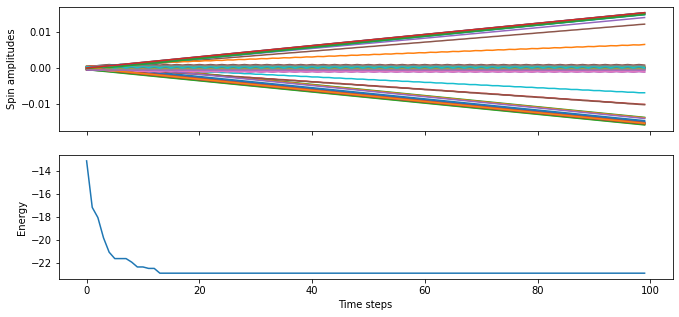

In [93]:
# num_anneals = 64
num_anneals = 40

N_steps = 100
time_step = 0.01
total_time = N_steps * time_step

r = 1
mu = 1
beta = 1
target_a_baseline = 0.4
gamma = 1/(N_steps * time_step)
coupling_str = 0.2

use_sign = 1
use_last = 0
add_noise = 0

#[25, 31, 37, 40, 69, 90, 94, 97, 110, 114, 132, 143, 162, 163, 171, 174, 185, 195]

wrong_problems =  [90]

#[69, 90, 94, 97, 110, 114, 132, 143, 162, 163, 171, 174, 185, 195]


# snr_list = [100]
# numInstances = 500

# ## Seed for verification
# np.random.seed(1)

numInstances= 200
for snr in snr_list:
    path_to_instances = path_to_all_instances + instance_type + str(snr) + "/"
    path_to_solutions = path_to_all_solutions + instance_type + str(snr) + "/"
    path_to_solved = path_to_all_solved + instance_type + str(snr) + "/"

    # Check whether the specified path exists or not
    isExist = os.path.exists(path_to_instances)

    if not isExist:
        print("No instances for snr = ", snr)

    # Check whether the specified path exists or not
    isExist = os.path.exists(path_to_solved)

    if not isExist:
        os.makedirs(path_to_solved)
        print("Created new directory for solved snr=", snr)

    for k in wrong_problems:
        file = open(path_to_instances + "DI_MIMO_J_Quad_" + str(k) + ".txt", "r")
        print("Reading file ", path_to_instances + "DI_MIMO_J_Quad_" + str(k) + ".txt")
        J = np.loadtxt(file)
        file.close()
        N = len(J)

        data, energies, solution, best_energy = CIM_AHC_alt_fixed(total_time, J, time_step, r=r, beta=beta, gamma=gamma, coupling_str=coupling_str, mu=mu, noise=0, num_anneals = num_anneals, target_a_baseline = 0.2, use_sign=1, modulate_parameter="target_a")

        #CIM_AHC_tf(total_time, J, time_step=time_step, \
         #   r=r, mu = 1, beta=beta, target_a_baseline=target_a_baseline, \
         #       num_anneals=num_anneals, coupling_str=coupling_str, \
          #      use_sign=use_sign, gamma=gamma, modulate_parameter="target_a", add_noise=add_noise) 
         #
        
        
          # target_a or coupling_str
                
        # print("Best energy = ", best_energy)
        
        print("Best energy = ", best_energy)
        
        # when solution is all zero, means the algorithm converge
        #n = 2*N_t
        #print("solution.shape=", solution.shape)
        #print(solution[0:n]+solution[n:2*n])
        
        file = open(path_to_solved +  "DI_MIMO_sol_" + str(k) + ".txt", "w")
        np.savetxt(file, solution, fmt="%s")
        file.close()

fig, ax = plt.subplots(2,1, sharex = True, figsize=(11,5))

for i in range(N):
    ax[0].plot(data[i,:])

print("SNR=", snr_list[-1])
ax[0].set_ylabel("Spin amplitudes")
ax[1].plot(energies)
ax[1].set_ylabel("Energy")
plt.xlabel("Time steps")

print(-1/2*J.dot(solution).dot(solution))


snr_list [30]
ber_mmse [0.0]
ber [0.00109375]
[90, 110, 143, 163]


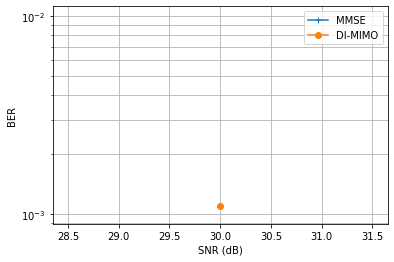

In [94]:
## This cell is to calculate the bit error rate once we have a solution

T = np.identity(2*N_t)
T = np.concatenate((T,T), axis=1)

ber = []
ber_mmse = []

numInstances = 200

wrongs = []
for snr in snr_list:
  path_to_instances = path_to_all_instances + instance_type + str(snr) + "/"
  path_to_solutions = path_to_all_solutions + instance_type + str(snr) + "/"
  path_to_solved = path_to_all_solved + instance_type + str(snr) + "/"

  # Check whether the specified path exists or not
  isExist = os.path.exists(path_to_instances)

  if not isExist:
      print("No instances for snr = ", snr)
      break
  
  isExist = os.path.exists(path_to_solved)

  if not isExist:
      print("No solved solutions for snr = ", snr)
      break
  bitErrors = 0
  bitErrors_mmse = 0

  #For Ising Solution s corresponding decoded symbol in
  for k in range(0,numInstances):
    # s = np.loadtxt(path_to_solved + "sol_" + str(k) + ".txt")
    file = open(path_to_solved + "DI_MIMO_sol_" + str(k) + ".txt", "r")
    s_quad = np.loadtxt(file)
    file.close()

    with open(path_to_solutions + "DI_MIMO_mmse_sol_" + str(k) + ".txt", "r") as file:
      x_mmse = np.loadtxt(file, dtype=np.complex128)

    s = s_quad[0:-1] * s_quad[-1]

    d = T@s
    x_mmse_r = np.concatenate((x_mmse.real,x_mmse.imag),axis=0)
    u = d + x_mmse_r

    u = u[0:N_t] + 1j*u[N_t:]

    b1 = _qam.demodulate(u,demod_type='hard')
    
    b_mmse = _qam.demodulate(x_mmse,demod_type='hard')

    with open(path_to_solutions + "DI_MIMO_sol_" + str(k) + ".txt", "r") as file:
      x = np.loadtxt(file, dtype=np.complex128)

    b2 = _qam.demodulate(x,demod_type='hard')
    if(sum(abs(b1-b2))!=0):
        wrongs.append(k)
    
    bitErrors = bitErrors + sum(abs(b1-b2))
    bitErrors_mmse = bitErrors_mmse + sum(abs(b_mmse-b2))
  
  ber.append(bitErrors/(totalBits*numInstances))
  ber_mmse.append(bitErrors_mmse/(totalBits*numInstances))

print("snr_list", snr_list)
print("ber_mmse", ber_mmse)
print("ber", ber)

plt.semilogy(snr_list, ber_mmse, "+-")
plt.semilogy(snr_list, ber, "o-")
plt.legend(["MMSE", "DI-MIMO"])
plt.grid(True, which="both")
plt.xlabel("SNR (dB)")
plt.ylabel("BER")
print(wrongs)

### Generate noise values for P-bit table.

In [219]:
import random 
#consts = [15,16,16,17,17,17,18,18,18,19,19,20]
#consts = [16,17,17,18,18,18,18,18, 19,19,20]
consts_alt = [16, 17,18, 18,19,19, 19, 20, 21]

#consts_alt = [13,14,15,16,18,19]


alt_big_rand_table = []
for i in range(200):
    noise = [0.01*np.random.normal(N)*0.7 for i in range(0,256)]
    alt_big_rand_table.append(noise)


print(alt_big_rand_table[1][0])



0.46950494835256384


### Generate Header file of noise values for HLS


In [300]:
import numpy as np

# Function to generate the noise values
def generate_noise_values():
    # Total of 100 sets, each containing 250 subsets of 65 values
    noise_values = []
    for _ in range(100):  # 100 sets
        for _ in range(250):  # Each set has 250 subsets
            noise = [0.007 * np.random.normal() for _ in range(65)]
            noise_values.append(noise)
    return noise_values

def write_to_header_file(values, filename="NoiseValues.h"):
    with open(filename, 'w') as file:
        file.write("#ifndef NOISE_VALUES_H\n")
        file.write("#define NOISE_VALUES_H\n\n")
        file.write("double noise_values[25000][65] = {\n")
        
        for row in values:
            file.write("    {")
            file.write(", ".join(f"{x:.6f}" for x in row))
            file.write("},\n")
        
        file.write("};\n\n")
        file.write("#endif // NOISE_VALUES_H\n")

# Generate the noise values
noise_values = generate_noise_values()

# Write to a header file
write_to_header_file(noise_values)


### P-bit floating pt. 

In [229]:
from fxpmath import Fxp
def P_bit_float(T_time, J, time_step, rand_table, ground_energy=0, num_anneals = 1, use_sign=1):
    np.random.seed(1)
    N = J.shape[1]

    ticks = int(T_time/time_step) #actual number of steps
    plot_data = np.zeros((N,ticks))

    best_energy = 0
    best_sol = None
    best_energies = None
    best_time = 0

    best_plot_data = None
    n_total = 20
    n_frac = 15

    A = J + np.eye(N)
    
    #A_fxp = Fxp(J, True, n_total, n_frac)
 #   J_fxp = Fxp(J, True, n_total, n_frac)

#    time_step_fxp = time_step
#    time_step_fxp = Fxp(time_step, True, n_total, n_frac)

    #rand_table_fxp = Fxp(rand_table, True, n_total, n_frac)

    for run in range(num_anneals):

    
        

        x = np.sign(np.random.randn(N))

     
        energies = []
        sig = np.sign(x)
        best_energy_run = -1/2*(J.dot(x)).dot(x)

        best_sol_run = x

        for t in range(ticks):
            plot_data[:,t] = x 
            # print("\nTime Step ", t)


            if t > 1:
                prev_signs = np.sign(plot_data[:, t-1])
                compare_signs = prev_signs != np.sign(x)
                comparison = compare_signs.any()
              
            if use_sign:
                MVM = A.dot(x)

            else:    
                MVM = (A).dot(x)
            
           # print(MVM)
            #print(x)
            x = np.sign(MVM + rand_table[run][t])
        

            #sig = np.sign(x)
            #Modulate Target Amplitude
         
            curr_ising_energy = -1/2*(J.dot(x)).dot(x)
            #print(curr_ising_energy)
            energies.append(curr_ising_energy)

            if curr_ising_energy < best_energy_run:
                best_energy_run = curr_ising_energy
                best_sol_run = x
                #print(x)
                best_time = t
            # if ground_energy != 0:
            #     if curr_ising_energy <= ground_energy:
            #         print("Solved at time ", t)
            #         return (plot_data, t)

        if best_energy_run < best_energy:
            best_energy = best_energy_run
            print(best_energy_run)
            
            best_sol = best_sol_run
            best_energies = energies
            best_plot_data = plot_data
    #print(best_sol)
    #print("BEST TIME")
    #print(best_time)
    
    return (best_plot_data, best_energies, np.sign(best_sol), best_energy)

In [292]:
from fxpmath import Fxp
def P_bit(T_time, J, time_step, rand_table, ground_energy=0, num_anneals = 1, use_sign=1):
    np.random.seed(1)
    N = J.shape[1]

    ticks = int(T_time/time_step) #actual number of steps
    plot_data = np.zeros((N,ticks))

    best_energy = 0
    best_sol = None
    best_energies = None
    best_time = 0

    best_plot_data = None
    n_total = 20
    n_frac = 15

    A = J + np.eye(N)
    
    #A_fxp = Fxp(J, True, n_total, n_frac)
    J_fxp = Fxp(J, True, n_total, n_frac)

    time_step_fxp = time_step
    time_step_fxp = Fxp(time_step, True, n_total, n_frac)

    #rand_table_fxp = Fxp(rand_table, True, n_total, n_frac)
    
    rand_table_fxp= numfi.numfi(rand_table, 1, n_total, n_frac, rounding='sat')
    
    #in end, no need to cast table noise to fixed-pt. numfi does automatically and casting makes i cripplingly slow.
    
    A_fxp = numfi.numfi(A, True, n_total, n_frac,rounding='sat')

    for run in range(num_anneals):

    
        

        x = np.sign(np.random.randn(N))
     
        energies = []
        sig = np.sign(x)
        curr_ising_energy = -1/2*(J.dot(x).dot(x))
        best_energy_run = curr_ising_energy

        best_sol_run = x

        for t in range(ticks):
            plot_data[:,t] = x 
            # print("\nTime Step ", t)


            if t > 1:
                prev_signs = np.sign(plot_data[:, t-1])
                compare_signs = prev_signs != np.sign(x)
                comparison = compare_signs.any()
              
            if use_sign:
                MVM = A_fxp.dot(x)

            else:    
                MVM = (A).dot(x)
            
            x = np.sign(MVM + rand_table[run][t])
  
         
            curr_ising_energy = -1/2*(J.dot(x)).dot(x)
            energies.append(curr_ising_energy)

            if curr_ising_energy < best_energy_run:
                best_energy_run = curr_ising_energy
                best_sol_run = x
                #print(x)
                best_time = t


        if best_energy_run < best_energy:
            best_energy = best_energy_run
            print(best_energy_run)
            
            best_sol = best_sol_run
            best_energies = energies
            best_plot_data = plot_data

    
    return (best_plot_data, best_energies, np.sign(best_sol), best_energy)

In [293]:
import random 
#consts = [15,16,16,17,17,17,18,18,18,19,19,20]
#consts = [16,17,17,18,18,18,18,18, 19,19,20]
consts_alt = [16, 17,18, 18,19,19, 19, 20, 21]

#consts_alt = [13,14,15,16,18,19]

#range_consts = [0.8,0.9,1,1.2,0.7,0.6, 0.2, 0.3, 0.1]
range_consts = [0.9, 0.8,0.4, 0.2, 0.3, 0.1, 0.09]

alt_big_rand_table = []
for i in range(200):
    noise = [np.random.randn(N)*range_consts[i%7] for i in range(0,256)]
    alt_big_rand_table.append(noise)


print(alt_big_rand_table[1][0])


[-0.32540289 -0.08304123 -0.15702724 -1.2037551  -0.05465429 -0.66598353
 -0.95821755 -0.98608222  0.92822555  0.36052137 -0.13003724  0.90633796
 -0.77261758 -0.26908309 -1.1635257  -0.11554176  0.07745293 -0.3456516
  0.23877089 -0.30629471 -1.72794859  0.28771961  1.10168425 -0.50823923
 -0.62638662  0.07660808  2.3193139  -2.07067893 -0.39281133 -0.15293747
  1.00628242 -0.67815708 -0.84595735 -0.22679826  0.27493906  0.40680404
  0.10829762 -1.95849117  0.85032944  0.40363741  0.21757776  0.18260715
  0.08519994  0.99436289 -1.44320012  0.72891339  0.4836945   0.20943826
  0.14394057  0.64855207 -0.84224898 -0.38703544  1.55123191 -1.96382472
  0.80784872 -0.38385067 -0.60449439  0.24075064 -0.41273369 -0.14587675
 -1.01131625 -1.33710002 -1.20072718 -0.61066473  0.3005479 ]


25
Reading file  ./tb_data/instances/Nt16_Nr16_16QAM/25/DI_MIMO_J_Quad_0.txt
-20.717393053873174
Best energy =  -20.717393053873174
SNR= 25
-20.717393053873174


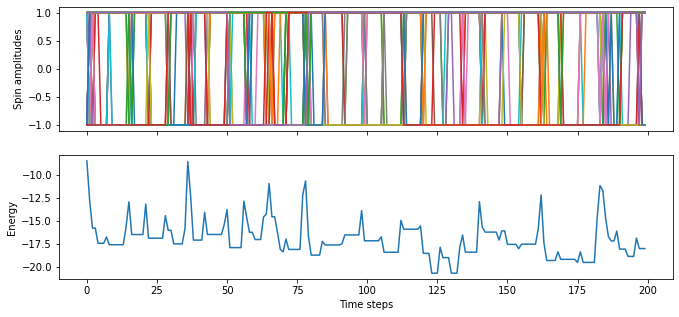

In [294]:
# num_anneals = 64
num_anneals = 1

N_steps = 200
time_step = 0.01
total_time = N_steps * time_step

r = 1
mu = 1
beta = 1
target_a_baseline = 0.2
gamma = 1/(N_steps * time_step)
coupling_str = 0.02

use_sign = 1
use_last = 0
add_noise = 0




# snr_list = [100]
# numInstances = 500

# ## Seed for verification
# np.random.seed(1)

numInstances= 1
for snr in snr_list:
    print(snr)
    path_to_instances = path_to_all_instances + instance_type + str(snr) + "/"
    path_to_solutions = path_to_all_solutions + instance_type + str(snr) + "/"
    path_to_solved = path_to_all_solved + instance_type + str(snr) + "/"

    # Check whether the specified path exists or not
    isExist = os.path.exists(path_to_instances)

    if not isExist:
        print("No instances for snr = ", snr)

    # Check whether the specified path exists or not
    isExist = os.path.exists(path_to_solved)

    if not isExist:
        os.makedirs(path_to_solved)
        print("Created new directory for solved snr=", snr)

    for k in range(0,numInstances):
    #in range(0, numInstances):
        file = open(path_to_instances + "DI_MIMO_J_Quad_" + str(k) + ".txt", "r")
        print("Reading file ", path_to_instances + "DI_MIMO_J_Quad_" + str(k) + ".txt")
        J = np.loadtxt(file)
        file.close()
        N = len(J)

        data, energies, solution, best_energy =  P_bit(total_time, J, time_step, alt_big_rand_table, ground_energy=0, num_anneals = num_anneals, use_sign=1)
        #CIM_AHC_tf(total_time, J, time_step=time_step, \
         #   r=r, mu = 1, beta=beta, target_a_baseline=target_a_baseline, \
         #       num_anneals=num_anneals, coupling_str=coupling_str, \
          #      use_sign=use_sign, gamma=gamma, modulate_parameter="target_a", add_noise=add_noise) 
         #
        
        
          # target_a or coupling_str
                
        # print("Best energy = ", best_energy)
        
        print("Best energy = ", best_energy)
        
        # when solution is all zero, means the algorithm converge
        #n = 2*N_t
        #print("solution.shape=", solution.shape)
        #print(solution[0:n]+solution[n:2*n])
        
        file = open(path_to_solved +  "DI_MIMO_p_bit_sol_" + str(k) + ".txt", "w")
        np.savetxt(file, solution, fmt="%s")
        file.close()

fig, ax = plt.subplots(2,1, sharex = True, figsize=(11,5))

for i in range(N):
    ax[0].plot(data[i,:])

print("SNR=", snr_list[-1])
ax[0].set_ylabel("Spin amplitudes")
ax[1].plot(energies)
ax[1].set_ylabel("Energy")
plt.xlabel("Time steps")

print(-1/2*J.dot(solution).dot(solution))

In [146]:
print(snr_list)
np.sign(np.sign(-1))

[25]


-1

Do simulation and draw for ideal solver

## Bit error rate

the plot is good for low snr

snr_list [25]
ber_mmse [0.0]
ber [0.0]
[]


c:\users\ari\programs\python\python38\lib\site-packages\matplotlib_inline\backend_inline.py:234: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  for label in axis.get_ticklabels()])


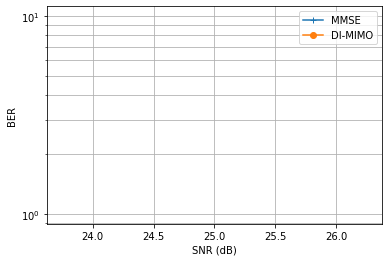

In [302]:
## This cell is to calculate the bit error rate once we have a solution

T = np.identity(2*N_t)
T = np.concatenate((T,T), axis=1)

ber = []
ber_mmse = []

wrong_instances = []

for snr in snr_list:
  path_to_instances = path_to_all_instances + instance_type + str(snr) + "/"
  path_to_solutions = path_to_all_solutions + instance_type + str(snr) + "/"
  path_to_solved = path_to_all_solved + instance_type + str(snr) + "/"

  # Check whether the specified path exists or not
  isExist = os.path.exists(path_to_instances)

  if not isExist:
      print("No instances for snr = ", snr)
      break
  
  isExist = os.path.exists(path_to_solved)

  if not isExist:
      print("No solved solutions for snr = ", snr)
      break
  bitErrors = 0
  bitErrors_mmse = 0

  #For Ising Solution s corresponding decoded symbol in
  for k in range(1,numInstances):
    # s = np.loadtxt(path_to_solved + "sol_" + str(k) + ".txt")
    file = open(path_to_solved + "DI_MIMO_p_bit_sol_" + str(k) + ".txt", "r")
    s_quad = np.loadtxt(file)
    file.close()

    with open(path_to_solutions + "DI_MIMO_mmse_sol_" + str(k) + ".txt", "r") as file:
      x_mmse = np.loadtxt(file, dtype=np.complex128)

    s = s_quad[0:-1] * s_quad[-1]

    d = T@s
    x_mmse_r = np.concatenate((x_mmse.real,x_mmse.imag),axis=0)
    u = d + x_mmse_r

    u = u[0:N_t] + 1j*u[N_t:]

    b1 = _qam.demodulate(u,demod_type='hard')
    
    b_mmse = _qam.demodulate(x_mmse,demod_type='hard')

    with open(path_to_solutions + "DI_MIMO_sol_" + str(k) + ".txt", "r") as file:
      x = np.loadtxt(file, dtype=np.complex128)

    b2 = _qam.demodulate(x,demod_type='hard')

    if(sum(abs(b1-b2))!=0):
        wrong_instances.append(k)
    bitErrors = bitErrors + sum(abs(b1-b2))
    bitErrors_mmse = bitErrors_mmse + sum(abs(b_mmse-b2))
  
  ber.append(bitErrors/(totalBits*numInstances))
  ber_mmse.append(bitErrors_mmse/(totalBits*numInstances))

print("snr_list", snr_list)
print("ber_mmse", ber_mmse)
print("ber", ber)

plt.semilogy(snr_list, ber_mmse, "+-")
plt.semilogy(snr_list, ber, "o-")
plt.legend(["MMSE", "DI-MIMO"])
plt.grid(True, which="both")
plt.xlabel("SNR (dB)")
plt.ylabel("BER")
print(wrong_instances)

# Failed numfi experiment for AHC. Will return to it later. 

In [ ]:
import numpy as np
from numfi import numfi

def CIM_AHC_np_fixed(T_time, J, time_step, r=0.2, beta=0.05, coupling_str=0.07, mu=1, gamma=1, noise=0, ground_energy=0, num_anneals=1, target_a_baseline=0.2, use_sign=0, modulate_parameter="target_a"):
    np.random.seed(1)
    N = J.shape[1]

    ticks = int(T_time / time_step)  # actual number of steps
    plot_data = np.zeros((N, ticks))

    best_energy = 0
    best_sol = None
    best_energies = None
    best_time = 0

    best_plot_data = None
    n_total = 32
    n_frac = 24

    # Convert matrix J and other parameters to fixed-point using numfi
    J_fxp = numfi.numfi(J, 1, n_total, n_frac, rounding='sat')

    time_step_fxp = numfi.numfi(time_step, 1, n_total, n_frac, rounding='sat')
    mu = numfi.numfi(mu, 1, n_total, n_frac, rounding='sat')
    beta = numfi.numfi(beta, 1, n_total, n_frac, rounding='sat')
    gamma = numfi.numfi(gamma, 1, n_total, n_frac, rounding='sat')

    r = numfi.numfi(r, 1, n_total, n_frac, rounding='sat')


    for run in range(num_anneals):
        target_a = numfi.numfi(target_a_baseline, 1, n_total, n_frac, rounding='sat')
        coupling_str = numfi.numfi(coupling_str, 1, n_total, n_frac, rounding='sat')

        x = 0.01 * np.random.rand(N) - 0.0005
        print(x)
        x = numfi.numfi(x, 1, n_total, n_frac, rounding='sat')
        print(x)
        error_var = np.ones(N)
        error_var = numfi.numfi(error_var, 1, n_total, n_frac, rounding='sat')

        sig = np.sign(x)
        best_energy_run = -0.5 * (J.dot(sig)).dot(sig)

        for t in range(ticks):
            plot_data[:, t] = x

            if use_sign:
                sig = numfi.numfi(np.sign(x), rounding='sat')
                MVM = J_fxp.dot(sig)
                print(type(MVM))
            else:
                MVM = J.dot(x)

            #print("error var is" , type(error_var))
            #print("coupling is" , type(coupling_str))

            #print("time step is" , type(time_step_fxp))
            #print(time_step_fxp)
            print("MVM", MVM)
            print("frac bits MVM", MVM.f)

            print("MVM*coupking_str", MVM*coupling_str)
            print("MVM*0.02", MVM*0.2)


            print("MVM*error_var", MVM*(error_var))


            deltax = (MVM * error_var)
            print("frac bits", deltax.f)
            deltax = numfi.numfi(deltax, 1, n_total, n_frac, rounding='sat')  # Adjust back to 24 fractional bits
            print("frac bits after cast", deltax.f)

            deltax *= time_step_fxp
            print("frac bits after *1", deltax.f)

            #print(deltax)
            #print("max deltax" , max(deltax))
            #print("type deltax" , type(deltax))

           # deltax *= 1
            #print(deltax)
            #print(x)
            deltax =  numfi.numfi(deltax, 1, n_total, n_frac, rounding='sat')

            x += deltax
        
            xx = x<<2
            #print("X is" , x)
            #print("mu*xx", mu*xx)
            #print("x*((r-1)-mux*xx)", (x * ((r - 1))-mu*xx))
            d#eltax = ((x * ((r - 1))-mu*xx))
            print("frac bits r-1", deltax.f)

            #print("DELTAX ", deltax)
            #print("X ", x)
            #deltax =  numfi.numfi(deltax*time_step_fxp, 1, n_total, n_frac, rounding='sat')

           # x += deltax
            #print("X type after add dx" , type(x))

            sig = np.sign(x)
            if modulate_parameter == "target_a":
                delta_a = Fxp((gamma * time_step_fxp), True, n_total, n_frac)
                target_a += delta_a
            elif modulate_parameter == "coupling_str":
                coupling_str += time_step_fxp * gamma

           
            xx = x << 2
            #print("xx-target_a", xx-target_a)
            #print("xx-target_a*error", (xx-target_a*error_var))
                            
            d_error_var= numfi.numfi(deltax, 1, n_total, n_frac, rounding='sat')

            d_error_var *= error_var

             
            d_error_var= numfi.numfi(deltax, 1, n_total, n_frac, rounding='sat')
            d_error_var *= -time_step_fxp
            error_var += numfi.numfi(d_error_var, 1, n_total, n_frac, rounding='sat')

            #* time_step_fxp
            sig = np.sign(x)
            curr_ising_energy = -0.5 * (J.dot(sig)).dot(sig)
            if curr_ising_energy < best_energy_run:
                best_energy_run = curr_ising_energy
                best_sol_run = x
                best_time = t

        if best_energy_run < best_energy:
            best_energy = best_energy_run
            best_sol = best_sol_run
            best_energies = energies
            best_plot_data = plot_data

    return (best_plot_data, best_energies, np.sign(best_sol()), best_energy)